## SASE pulse --> 220-DBM --> XPR

In [117]:
import numpy as np
import matplotlib.pyplot as plt

from tools import Ocelot_SASE_seed_220_dbm_pstxy
from o_globals import *

# central photon energy and bandwidth specs
E0_eV     = 8048.0     # eV
fwhm_E_eV =   33.0     # eV

# conversions
sigma_E_eV         =   fwhm_E_eV / (2 * np.sqrt(2 * np.log(2)))
X_bandwidth        =   sigma_E_eV * 2 / E0_eV
X_lambdaKalpha1N   =   h_eV_s * speed_of_light / E0_eV * 1e9

class SimObject: pass
X = SimObject()

# spectral / FEL params
X.seed_FEL_bandwidth = X_bandwidth         
X.lambdaKalpha1N     = h_eV_s * speed_of_light / E0_eV * 1e9    # nm
X.hwKalpha1N         = E0_eV                                    # eV
X.hbar               = hr_eV_s                                  # eV·s
X.Gamma_sp_fsm1N     = 1.0                                      # arbitrary units
X.E_seed_uJ          = 0.03                                     # seed pulse energy [μJ]
X.seed_delay         = 0                                        # s

# desired pulse shape (FWHMs in nm or fs)
X.config = {
    'seed_width_FWHM_x'    : 10.0,   # nm
    'seed_width_FWHM_y'    : 10.0,   # nm
    #'seed_duration_FWHM_t' : 4 * np.log(2) * h_J_s / 2 / pi / fwhm_E_eV / q_e * 1e15,   # fs
    'seed_duration_FWHM_t' : 20.0,   # fs
}

# grid sizes
X.xgrid, X.ygrid, X.tgrid  = 20, 20, 2000
X.xmax,  X.ymax,  X.tmax   = 20.0, 20.0, 200  # nm, nm, fs

# step‐sizes
X.dx = (2 * X.xmax) / X.xgrid     # nm
X.dy = (2 * X.ymax) / X.ygrid     # nm
X.dt =      X.tmax  / X.tgrid     # fs

# for plotting
X.t = np.linspace(0, X.tmax, X.tgrid)  # fs
X.x = np.linspace(-X.xmax, X.xmax, X.xgrid)
X.y = np.linspace(-X.ymax, X.ymax, X.ygrid)

In [118]:
Omega = Ocelot_SASE_seed_220_dbm_pstxy(X)

# Omega has shape (2,2,t,x,y); the linear‐y component is Omega[0,1]
field = Omega[0,1]   # complex array shape (t, x, y)

"scale_kz" will be deprecated, use "grid_z and grid_kz" instead


number of seed photons = 2.3e+07


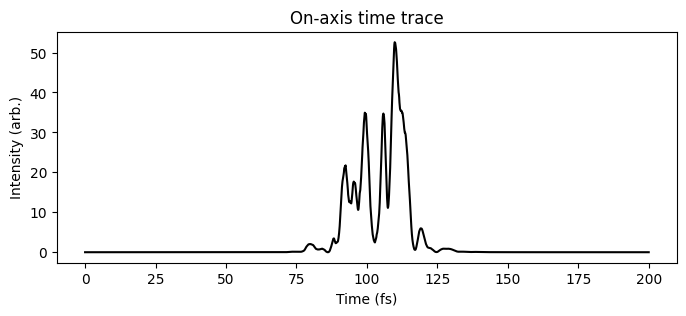

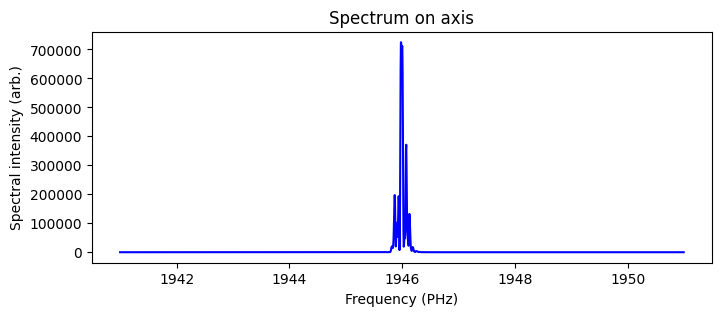

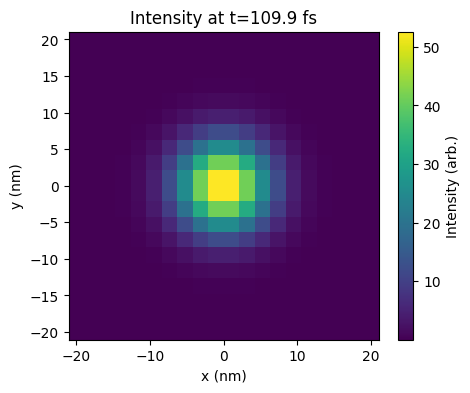

In [119]:
ix0, iy0 = X.xgrid//2, X.ygrid//2
I_t      = np.abs(field[:, ix0, iy0])**2                 # arb. units

# time‐domain
plt.figure(figsize=(8,3))
plt.plot(X.t, I_t, '-k')
plt.xlabel('Time (fs)')
plt.ylabel('Intensity (arb.)')
plt.title('On-axis time trace')
plt.show()

# freq‐domain (THz)
freqs_Hz = (np.fft.fftshift(np.fft.fftfreq(X.tgrid, d=X.dt*1e-15)) + E0_eV / h_eV_s)
spec = np.fft.fftshift(np.fft.fft(field[:,ix0,iy0]))

plt.figure(figsize=(8,3))
plt.plot(freqs_Hz * 1e-15, np.abs(spec)**2, '-b')
#plt.plot(freqs_Hz * 1e-15, np.angle(spec), '-r')
plt.xlabel('Frequency (PHz)')
plt.ylabel('Spectral intensity (arb.)')
plt.title('Spectrum on axis')
plt.show()

t_peak = np.argmax(I_t)
I_xy   = np.abs(field[t_peak])**2

Xg, Yg = np.meshgrid(X.x, X.y, indexing='ij')

plt.figure(figsize=(5,4))
plt.pcolormesh(Xg, Yg, I_xy, shading='auto')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.title(f'Intensity at t={X.t[t_peak]:.1f} fs')
plt.colorbar(label='Intensity (arb.)')
plt.show()

In [120]:
from XPR import *

t = 0.5e-3

E_array_J = freqs_Hz * h_J_s
theta = np.linspace(37.55,37.75, 1000)
#theta = np.linspace(37.4,37.9, 1000)

"""
def bandwidth_avg_Ixy(E_array_J, t, theta):
  Tsigma = calculate_sigma(E_array_J, t, theta)[-1]
  Tpi = calculate_pi(E_array_J, t, theta)[-1]
  additional_phase = np.exp(1j*E_array_J/hbar/c*np.cos(theta)*t)
  norm = np.sum(np.abs(spec))
  Tsigma_weighted = Tsigma * np.abs(spec) / norm #* additional_phase
  Tpi_weighted = Tpi * np.abs(spec) / norm #* additional_phase
  #Tsigma_weighted = Tsigma * spec / norm #* additional_phase
  #Tpi_weighted = Tpi * spec / norm #* additional_phase

  Tx = 1 / np.sqrt(2) * np.sum((Tsigma_weighted + Tpi_weighted)) 
  Ty = 1 / np.sqrt(2) * np.sum((Tsigma_weighted - Tpi_weighted)) # Sum before taking mod
  
  return np.abs(Tx)**2, np.abs(Ty)**2
"""

def bandwidth_avg_Ixy(E_array_J, t, theta):
  Tsigma = calculate_sigma(E_array_J, t, theta)[-1]
  Tpi = calculate_pi(E_array_J, t, theta)[-1]
  additional_phase = np.exp(1j*E_array_J/hbar/c*np.cos(theta)*t)
  norm = np.sum(np.abs(spec))
  Tsigma_weighted = Tsigma * np.abs(spec) / norm #* additional_phase
  Tpi_weighted = Tpi * np.abs(spec) / norm #* additional_phase
  #Tsigma_weighted = Tsigma * spec / norm #* additional_phase
  #Tpi_weighted = Tpi * spec / norm #* additional_phase
  Ix = 1 / np.sqrt(2) * np.sum(np.abs(Tsigma_weighted + Tpi_weighted)**2) 
  Iy = 1 / np.sqrt(2) * np.sum(np.abs(Tsigma_weighted - Tpi_weighted)**2) # Mod before sum
  return Ix, Iy

  
Ix = [bandwidth_avg_Ixy(E_array_J, t, theta_val)[0] for theta_val in theta]
Iy = [bandwidth_avg_Ixy(E_array_J, t, theta_val)[1] for theta_val in theta]

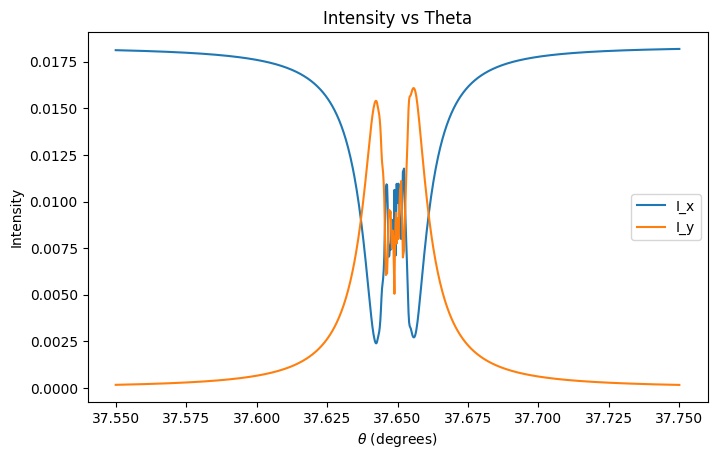

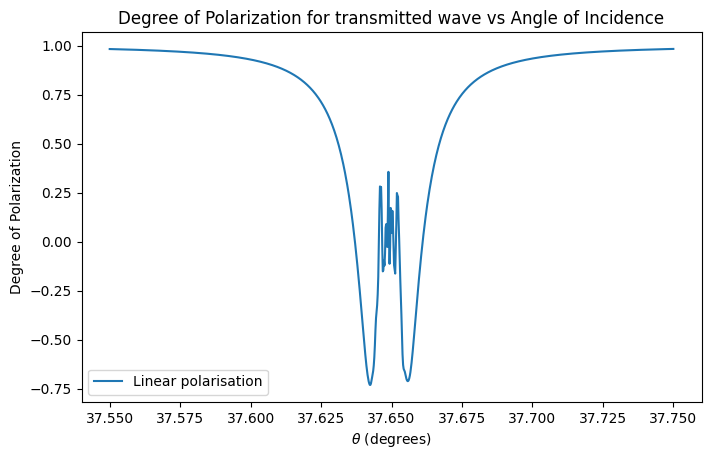

In [121]:
plt.figure(figsize=(8, 4.8))
plt.plot(theta, Ix, label='I_x')
plt.plot(theta, Iy, label='I_y')
plt.xlabel(r"$\theta$ (degrees)")
plt.ylabel('Intensity')
plt.title('Intensity vs Theta')
plt.legend() 
plt.show()

plt.figure(figsize=(8, 4.8))
plt.plot(theta, [(Ix[i] - Iy[i]) / (Ix[i] + Iy[i]) for i in range(len(Ix))],
                 label = "Linear polarisation")
#plt.plot(theta, 2*np.imag(Tsigma * np.conj(Tpi))/
#                (np.abs(Tsigma)**2 + np.abs(Tpi)**2), 
#                label = "Circular polarisation")

#plt.plot(theta, [np.sin(np.angle(Tsigma[i])-np.angle(Tpi[i])) for i in range(len(Tsigma))],
#         label = "Circular polarisation")
#plt.plot(theta, [4*xi[i]*np.cos(np.angle(Tsigma[i])-np.angle(Tpi[i])) / (2+2*xi[i]**2) for i in range(len(Tsigma))])

plt.legend()
plt.xlabel(r"$\theta$ (degrees)")
plt.ylabel("Degree of Polarization")
plt.title("Degree of Polarization for transmitted wave vs Angle of Incidence")
plt.show()